<a href="https://colab.research.google.com/github/ShivinM-17/Tensorflow_practises/blob/main/NLP_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Natural Language Processing using Tensorflow

NLP - goal is to derive information out of natural language

Common term for NLP problems is sequence to sequence problems (seq2seq)


### Check for GPU

In [1]:
!nvidia-smi

Tue Nov 28 05:36:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-11-28 05:36:31--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-28 05:36:32 (87.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



### Get a text dataset

Here, we will be using is Kaggle's introduction to NLP dataset (text samples of Tweets on whether the message is labelled as disaster or not)

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip the data
unzip_data("nlp_getting_started.zip")

--2023-11-28 05:36:36--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.207, 173.194.192.207, 209.85.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2023-11-28 05:36:36 (109 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



### Visualizing a text dataset

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df['text'][3]

'13,000 people receive #wildfires evacuation orders in California '

In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state = 42)
train_df_shuffled

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0
...,...,...,...,...,...
5226,7470,obliteration,Merica!,@Eganator2000 There aren't many Obliteration s...,0
5390,7691,panic,NaN,just had a panic attack bc I don't have enough...,0
860,1242,blood,NaN,Omron HEM-712C Automatic Blood Pressure Monito...,0
7603,10862,NaN,NaN,Officials say a quarantine is in place at an A...,1


In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class present
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Since, here there is around 60% - 40% split between the 0 and 1 target values, therefore, this is a balanced dataset

In [9]:
# How many total samples are present?
len(train_df), len(test_df)

(7613, 3263)

In [10]:
# Visualizing some random training samples
import random
random_index = random.randint(0, len(train_df)-5)  # Create random indexes

for row in train_df_shuffled[['text', 'target']][random_index : random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
Stay vigilent. Civil liberties are under constant attack. #nativehuman #myreligion  https://t.co/WWu070Tjej

---

Target: 0 (not real disaster)
Text:
Businesses are deluged with invoices. Make yours stand out with colour or shape and it's likely to ris. togthe top of the pay' pile.

---

Target: 1 (real disaster)
Text:
Beat:B2 MOTOR VEHICLE COLLISION at N 35 ST / FREMONT AV N reported on 8/5/2015 6:52 PM Call# 15000270364

---

Target: 0 (not real disaster)
Text:
SEAN END CAREER sG Blizzard vs KNOCKOUT ... http://t.co/nyv51681uE

---

Target: 0 (not real disaster)
Text:
I liked a @YouTube video http://t.co/YdgiUYdqgb Mini Pony packs a punch. Live report from the Salem County Fair on CBS3 Eyewitness

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels  = train_test_split(train_df_shuffled['text'].to_numpy(),
                                                                             train_df_shuffled['target'].to_numpy(),
                                                                             test_size=0.1,
                                                                             random_state=42)

In [12]:
# Check the lengths
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

### Converting text into numbers

When dealing with text data, the first thing that should be done is to convert the text into numbers

Few ways of doing this:
* Tokenization - direct making of tokens (tokens can be a word or a character)
* Embedding - creating a matrix of feature vector for each token

#### Text vectorization (tokenization)

In [14]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [15]:
# Performing tokenization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# use the default text vectorization
text_vectorizer = TextVectorization(max_tokens = 10000, # count of words in the vocabulary
                                    standardize="lower_and_strip_punctuation",
                                    split='whitespace',
                                    ngrams=None, # Create groups of n words
                                    output_mode = "int", # Mapping the text into integers
                                    output_sequence_length = None,  # How long the sequence must be
                                    pad_to_max_tokens = True
                                    )

In [16]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [17]:
# Setup text vectorization variables
max_vocab_length = 10000   # Max number of words in the vocabulary
max_length = 15  # max length of the sequences of tokens we see in a tweet (on a averagee)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length, # count of words in the vocabulary
                                    output_mode = "int", # Mapping the text into integers
                                    output_sequence_length = max_length,  # How long the sequence must be
                                    )

In [18]:
# Fit the vectorizer to the train data
text_vectorizer.adapt(train_sentences)

In [19]:
sample_sentence = "There's a flood in the streets"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 264,    3,  232,    4,    2, 1585,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [20]:
# Choosing random sentences from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
      \n\nVectorizered version:")
text_vectorizer([random_sentence])

Original text:
 Detonation fashionable mountaineering electronic watch water-resistant couples leisure tabÛ_ http://t.co/UCAwg59ulJ http://t.co/eNqDfbJUMP      

Vectorizered version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 580, 3859, 3610, 2128,  135, 3258, 3083, 3681, 3358,    1,    1,
           0,    0,    0,    0]])>

In [21]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()  # get all unique words in the dataset
top_5_words = words_in_vocab[:5]   # Most common words
bottom_5_words = words_in_vocab[-5:]  # least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating embedding using an Embedding Layer

Here, we will use tensorflow's embedding layer.

Here, the parameters used are:
* `input_dim`: size of the vocabulary
* `output_dim`: size of the output embedding vector, eg. a value of 100 would mean each token gets represented by a vector 100 long
* `input_length`: length of the sequences being passed to the embedding layer

In [22]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length,   # set input shape
                             output_dim=128,   # output shape
                             input_length = max_length,    # how long is each input
                             embeddings_initializer="uniform"
                             )
embedding

In [23]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Oringal text:\n {random_sentence}\
      \n\nEmbedded version: ")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Oringal text:
 @welshninja87 click on the tag there's lots of them. RT them to hijack the hashtag      

Embedded version: 


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00677859,  0.02190015,  0.01737007, ..., -0.02407655,
          0.0146344 , -0.03997114],
        [-0.00428184,  0.00642917,  0.04052028, ..., -0.03719159,
          0.0310251 ,  0.02675898],
        [-0.02233562,  0.00421648,  0.03847306, ...,  0.03316797,
         -0.04958534,  0.00175772],
        ...,
        [ 0.00170026, -0.02316728, -0.00839777, ..., -0.04876706,
         -0.02539863, -0.02695577],
        [ 0.01773491,  0.01653937, -0.01343698, ...,  0.02281077,
          0.03941809, -0.03554634],
        [-0.03841989,  0.03060791,  0.02251149, ..., -0.03674082,
         -0.00017506, -0.00333816]]], dtype=float32)>

In [24]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00677859,  0.02190015,  0.01737007,  0.04853481, -0.03481646,
        -0.04318152, -0.03224778,  0.0338514 ,  0.04695853,  0.00041042,
         0.00377293, -0.01195019, -0.0246413 ,  0.04960133,  0.02191324,
        -0.03980631,  0.0357192 ,  0.01562445, -0.01748119, -0.00840499,
         0.04818661, -0.03232361,  0.0172343 , -0.02653386, -0.04090259,
        -0.01955242, -0.02256476,  0.03500799, -0.00062443, -0.03071621,
        -0.02470137,  0.03275562,  0.00053152, -0.04695505, -0.03818904,
        -0.01628907,  0.04202597,  0.01013432, -0.03996821, -0.02092209,
        -0.01890867,  0.01606952,  0.0300671 , -0.0246963 , -0.04436427,
         0.02208127,  0.02139448, -0.00372498, -0.0038259 , -0.03405948,
        -0.04530643, -0.04252194,  0.01191318,  0.00175412,  0.03476265,
        -0.02343891,  0.031173  ,  0.04459381,  0.04848823, -0.01854352,
        -0.02955656, -0.03802636,  0.03296257,  0.04162482,  0.01996268,
  

### Modelling the text dataset (running a series of experiments)

Here are the models to be made:
* Model 0: Naive Bayes (Baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional-LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

Steps to approach these model:
* Create a model
* Build a model
* Fit a model
* Evaluate our model

#### Model 0 - Baseline model

Here, using Multinomial Naive Bayes using TF-IDF formula to convert the words to numbers

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [26]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline line model achieves accuracy of: {baseline_score*100:.2f}%")

Baseline line model achieves accuracy of: 79.27%


In [27]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [29]:
train_labels

array([0, 0, 1, ..., 1, 1, 0])

### Creating an evaluation function for the model experience

This function will compare the model's predictions with the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-score

In [30]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model's accuracy, precision, recall and F1-score of a binary classifaciton model
  """
  # Calculate model's accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100

  # Calculate model's precision, recall and f1-score using 'weighted' accuracy
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                               y_pred,
                                                                               average='weighted')
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall":model_recall,
                   "f1":model_f1}
  return model_results

In [31]:
# Get baseline results
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: Feed forward simple dense model

In [32]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback


# Create a directory to save Tensorboard logs
SAVE_DIR = "model_logs"

In [33]:
# Build model with the function API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)  # turn the input text into numbers
x = embedding(x)  # turn the numbers into embeddings
# x = layers.GlobalAveragePooling1D()(x)  # condense the feature vector
x = layers.GlobalMaxPooling1D()(x)  # condense the feature vector
outputs = layers.Dense(1, activation='sigmoid')(x) # Create the output layer

model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [34]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [35]:
# Compile the model
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [36]:
train_sentences.shape, train_labels.shape

((6851,), (6851,))

In [37]:
# Fit the model
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                       experiment_name = "model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20231128-053646
Epoch 1/5
215/215 [==============================] - 19s 45ms/step - loss: 0.6368 - accuracy: 0.6560 - val_loss: 0.5753 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4723 - accuracy: 0.8212 - val_loss: 0.4772 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3447 - accuracy: 0.8733 - val_loss: 0.4553 - val_accuracy: 0.7848
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2610 - accuracy: 0.9056 - val_loss: 0.4551 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2006 - accuracy: 0.9343 - val_loss: 0.4660 - val_accuracy: 0.7861


In [38]:
# Check the model results  - Global Average pooling
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4660 - accuracy: 0.7861


[0.4659789204597473, 0.7860892415046692]

In [39]:
# Check the model results  - Global Max pooling
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4660 - accuracy: 0.7861


[0.4659789204597473, 0.7860892415046692]

In [40]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

24/24 [==============================] - 0s 2ms/step


array([[0.36360395],
       [0.83747995],
       [0.9932301 ],
       [0.05429823],
       [0.2796631 ],
       [0.9533979 ],
       [0.92966425],
       [0.9850162 ],
       [0.89917207],
       [0.08382781],
       [0.15266898],
       [0.71150464],
       [0.10530345],
       [0.15720043],
       [0.01723434],
       [0.02161844],
       [0.02832342],
       [0.26784697],
       [0.19495271],
       [0.51609814],
       [0.98170644],
       [0.05331754],
       [0.4634712 ],
       [0.04144498],
       [0.9364451 ],
       [0.9959015 ],
       [0.02150123],
       [0.09151212],
       [0.03188843],
       [0.11500926],
       [0.7112812 ],
       [0.36857507],
       [0.4741655 ],
       [0.4277267 ],
       [0.62340343],
       [0.10820091],
       [0.99698156],
       [0.05001326],
       [0.02210267],
       [0.9938041 ],
       [0.08720532],
       [0.08532766],
       [0.4541945 ],
       [0.06771345],
       [0.344184  ],
       [0.98420584],
       [0.09375034],
       [0.942

In [41]:
# Checking out the first 10 pred probs
model_1_pred_probs[:10]

array([[0.36360395],
       [0.83747995],
       [0.9932301 ],
       [0.05429823],
       [0.2796631 ],
       [0.9533979 ],
       [0.92966425],
       [0.9850162 ],
       [0.89917207],
       [0.08382781]], dtype=float32)

In [42]:
# Convert the model predicitons probabilities to label formats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [43]:
# Calculate model results
model_1_results =calculate_results(y_true = val_labels,
                                   y_pred = model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

In [44]:
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

### Visualizing learned embeddings

In [45]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [46]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [47]:
# Get the weight matrix of embedding layer
# These are the numerical representations of each token in the training data
embed_weights = model_1.get_layer('embedding').get_weights()[0]
embed_weights

array([[ 0.12028379, -0.07271183, -0.02002266, ..., -0.04622614,
        -0.02985782, -0.02316393],
       [-0.04838066, -0.07044202, -0.03576634, ..., -0.04741573,
        -0.03704569, -0.03502283],
       [-0.02178733, -0.05431573, -0.03657129, ..., -0.03130871,
        -0.03780035, -0.03554634],
       ...,
       [ 0.00728294,  0.03250079,  0.01042386, ...,  0.0051899 ,
        -0.02619978,  0.01008813],
       [-0.03194616, -0.01574296, -0.04716647, ..., -0.02276018,
        -0.03359552, -0.0436954 ],
       [-0.03863217, -0.03120137,  0.03949908, ...,  0.01068245,
         0.06293058,  0.03751821]], dtype=float32)

Visualising the embedding matrix, after learned from the model.

To visualize it, we use a tensorflow tool called projector

In [48]:
embed_weights.shape  # same size as vocab size

(10000, 128)

In [49]:
# Create embedding files
import io

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [50]:
# Download files from colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Recurrent Neural Networks

RNN's are useful for sequence data

The premise of a RNN is to use the representation of a previous input to aid the representation of a later input.

#### Model 2: LSTM

LSTM - long short term memory

In [51]:
# Create a LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
x = layers.LSTM(units = 64, return_sequences=True)(x)  # use multples of 8, to speed up the computation on the GPU
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
x = layers.Dense(64, activation='relu')(x)
# print(x.shape)
outputs = layers.Dense(1, activation='sigmoid')(x)
# print(x.shape)

model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [52]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                      

In [53]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [54]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     experiment_name="model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231128-053716
Epoch 1/5
215/215 [==============================] - 16s 46ms/step - loss: 0.3786 - accuracy: 0.8349 - val_loss: 0.4832 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2471 - accuracy: 0.9002 - val_loss: 0.4966 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1830 - accuracy: 0.9321 - val_loss: 0.7015 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1357 - accuracy: 0.9514 - val_loss: 0.6584 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0981 - accuracy: 0.9631 - val_loss: 0.8520 - val_accuracy: 0.7651


In [55]:
# Make predictions with the LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[0.05533263],
       [0.9223951 ],
       [0.9999534 ],
       [0.05972917],
       [0.00533958],
       [0.9999831 ],
       [0.9758213 ],
       [0.9999902 ],
       [0.99998915],
       [0.7421647 ]], dtype=float32)

In [56]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [57]:
# Calculate model 2 results
model_2_results = calculate_results(y_true = val_labels,
                                    y_pred = model_2_preds)
model_2_results

{'accuracy': 76.50918635170603,
 'precision': 0.76472972449374,
 'recall': 0.7650918635170604,
 'f1': 0.7644302589305015}

In [58]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [59]:
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7903277546022673,
 'recall': 0.7860892388451444,
 'f1': 0.7832971347503846}

#### Model 3: GRU

GRU - Gated recurrent unit

The GRU cell has similar features to a LSTM cells but has less parameters

In [60]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
# # print(x.shape)
# x = layers.GRU(64, return_sequences=True)(x)  # if you want to stack recurrent layers on each other, do return_sequences = True
# # print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x)
# # print(x.shape)
# x = layers.GRU(32)(x)
# # print(x.shape)
# x = layers.Dense(64, activation='relu')(x)
x= layers.GRU(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='model_4_GRU')

In [61]:
# Get the summary
model_3.summary()

Model: "model_4_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [62]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [63]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                       experiment_name="model_4_GRU")])

Saving TensorBoard log files to: model_logs/model_4_GRU/20231128-053803
Epoch 1/5
215/215 [==============================] - 13s 45ms/step - loss: 0.2163 - accuracy: 0.9095 - val_loss: 0.6290 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0984 - accuracy: 0.9648 - val_loss: 0.6888 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.0757 - accuracy: 0.9688 - val_loss: 0.8857 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0603 - accuracy: 0.9756 - val_loss: 1.0901 - val_accuracy: 0.7677
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0506 - accuracy: 0.9777 - val_loss: 1.4375 - val_accuracy: 0.7651


In [64]:
# Make predictions using the model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs

24/24 [==============================] - 0s 3ms/step


array([[1.59829296e-02],
       [6.90366864e-01],
       [9.99814808e-01],
       [1.69967301e-02],
       [8.70465083e-05],
       [9.99808371e-01],
       [3.65119539e-02],
       [9.99938011e-01],
       [9.99927998e-01],
       [8.51494074e-01],
       [1.14090828e-04],
       [9.71100390e-01],
       [1.60489639e-04],
       [1.08539321e-01],
       [5.37321248e-05],
       [4.75795357e-04],
       [9.19974918e-05],
       [4.44823236e-04],
       [2.08221772e-03],
       [9.99870658e-01],
       [9.99896765e-01],
       [2.56826625e-05],
       [9.99918222e-01],
       [1.49552361e-04],
       [9.99905109e-01],
       [9.99943972e-01],
       [8.43623202e-05],
       [2.48966535e-04],
       [5.84009395e-04],
       [4.27704901e-01],
       [9.99246120e-01],
       [1.79920913e-04],
       [2.12533007e-04],
       [1.10026821e-03],
       [9.75371122e-01],
       [4.08110946e-01],
       [9.99847651e-01],
       [1.25512183e-01],
       [5.38134831e-04],
       [9.99832273e-01],


In [65]:
# Convert the pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [66]:
# Calculate model 3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.50918635170603,
 'precision': 0.7669456967235844,
 'recall': 0.7650918635170604,
 'f1': 0.7627590065822708}

#### Model 4: Bidirectional RNN

Normal RNN's go from left to right, but these bi-directional RNNs go via both directions.

It combines the representations from left-to-right, as well as right-to-left.

In [67]:
# Build a bi-directional rnn
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(inputs, outputs, name='model_4_biRNN')

In [68]:
# Get the model summary
model_4.summary()

Model: "model_4_biRNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 15, 128)           98816     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                     

In [69]:
# Compile the model;
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [70]:
# Fit the model;
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_4_bidirectional")])


Saving TensorBoard log files to: model_logs/model_4_bidirectional/20231128-053828
Epoch 1/5
215/215 [==============================] - 18s 53ms/step - loss: 0.1253 - accuracy: 0.9517 - val_loss: 0.8884 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0593 - accuracy: 0.9747 - val_loss: 1.1820 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0527 - accuracy: 0.9775 - val_loss: 1.0909 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0517 - accuracy: 0.9766 - val_loss: 1.2287 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.0478 - accuracy: 0.9766 - val_loss: 1.3275 - val_accuracy: 0.7664


In [71]:
# Make predictions using the model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[1.7867496e-02],
       [7.8075922e-01],
       [9.9981862e-01],
       [2.2967426e-01],
       [4.9109469e-05],
       [9.9977940e-01],
       [5.1234905e-03],
       [9.9991560e-01],
       [9.9989438e-01],
       [7.5964308e-01]], dtype=float32)

In [72]:
# Convert the pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [73]:
# Calculate the results of the model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657,
 'f1': 0.7651213533864446}

### Convolutional Neural networks for TEXT (and other types of sequences)

Here, the text data is of 1D. So we will be using Conv1D, instead of the Conv2D (which is used for images, which are 2D in nature)


```
Inputs (text) -> Tokenization -> Embedding -> Layer(s) (typically Conv1D + pooling) -> Outputs (class probs)
```

#### Model 5: Conv1D

In [74]:
# Test out the embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(['this is a test sentence']))
conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5,
                        strides=1,
                        activation='relu',
                        padding='same')
conv_1d_output = conv_1d(embedding_test)  # pass test ebedding to the conv1d layer
max_pool = layers.GlobalMaxPooling1D()
max_pool_output = max_pool(conv_1d_output)  # get the most important feature

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 15, 32]), TensorShape([1, 32]))

In [75]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.00512882, -0.08654398, -0.05369894, ..., -0.0137938 ,
          0.00306223, -0.01618994],
        [ 0.00143893, -0.05350533,  0.08724065, ..., -0.03096534,
          0.04090209, -0.03460586],
        [-0.015231  , -0.07970208, -0.01690694, ..., -0.02490725,
         -0.00435862, -0.01266957],
        ...,
        [ 0.07067342, -0.06817597, -0.00477996, ..., -0.02967818,
         -0.00214879, -0.03890475],
        [ 0.07067342, -0.06817597, -0.00477996, ..., -0.02967818,
         -0.00214879, -0.03890475],
        [ 0.07067342, -0.06817597, -0.00477996, ..., -0.02967818,
         -0.00214879, -0.03890475]]], dtype=float32)>

In [76]:
conv_1d_output

<tf.Tensor: shape=(1, 15, 32), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        , 0.        , 0.01295389,
         0.01381272, 0.02030746, 0.        , 0.08734667, 0.08817729,
         0.        , 0.        , 0.05692339, 0.        , 0.02444499,
         0.        , 0.00137386, 0.0009152 , 0.01018078, 0.00525055,
         0.00346729, 0.        , 0.02685446, 0.02588347, 0.        ,
         0.03276296, 0.0667178 , 0.        , 0.13913442, 0.        ,
         0.        , 0.00852624],
        [0.00795098, 0.        , 0.03141601, 0.        , 0.        ,
         0.        , 0.05494271, 0.        , 0.        , 0.06546172,
         0.01625365, 0.        , 0.02295608, 0.01065775, 0.0588729 ,
         0.        , 0.07761824, 0.        , 0.02317763, 0.04539752,
         0.        , 0.        , 0.09523603, 0.        , 0.        ,
         0.03168216, 0.04951976, 0.        , 0.04648129, 0.        ,
         0.03555238, 0.026187  ],
        [0.        , 0.        , 0.06951462, 0.    

In [77]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.10607652, 0.06626344, 0.13141221, 0.        , 0.01295389,
        0.10676078, 0.05494271, 0.05453813, 0.08734667, 0.09855124,
        0.1249997 , 0.02339372, 0.07013492, 0.0436017 , 0.08606368,
        0.0299898 , 0.13722005, 0.03801657, 0.03031671, 0.07746231,
        0.03391843, 0.01031179, 0.09523603, 0.02588347, 0.01071147,
        0.09556258, 0.14995965, 0.10612688, 0.13913442, 0.00354173,
        0.03555238, 0.11912954]], dtype=float32)>

In [78]:
# Create 1D convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', padding='valid')(x)
x = layers.GlobalMaxPooling1D()(x)

outputs = layers.Dense(1, activation='sigmoid')(x)
model_5 = tf.keras.Model(inputs, outputs, name='model_5_Conv1D')

In [79]:
# Compile the model
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [80]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_conv1d")])

Saving TensorBoard log files to: model_logs/model_conv1d/20231128-053904
Epoch 1/5
215/215 [==============================] - 10s 34ms/step - loss: 0.1519 - accuracy: 0.9545 - val_loss: 0.8476 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.0774 - accuracy: 0.9726 - val_loss: 0.9478 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0627 - accuracy: 0.9759 - val_loss: 1.0676 - val_accuracy: 0.7467
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.0561 - accuracy: 0.9778 - val_loss: 1.1142 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0512 - accuracy: 0.9800 - val_loss: 1.1591 - val_accuracy: 0.7598


In [81]:
# Make some predictions with the model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[2.2515774e-02],
       [6.5290678e-01],
       [9.9993169e-01],
       [5.5508364e-02],
       [1.8962091e-05],
       [9.7458827e-01],
       [4.0774578e-01],
       [9.9994707e-01],
       [9.9999928e-01],
       [6.3377607e-01]], dtype=float32)

In [82]:
# Convert the pred probs to pred labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 0., 1., 1., 1.], dtype=float32)>

In [83]:
# Calculate the metrics of the model
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.98425196850394,
 'precision': 0.7618096125081139,
 'recall': 0.7598425196850394,
 'f1': 0.7573149475055201}

### Model 6: Tensorflow pretrained sentence encoder

These models use models to convert text vectors into embedding specifically for transfer learning use cases models.

Now, here we will be using transfer learning to make the model, and to make the appropriate embeddings, we use the Universal Sentence Encoder.

In [84]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                       "When you call the universal sentence encoder, it turns it into numbers"])
print(embed_samples[0][:50])

tf.Tensor(
[-0.04195761  0.01448233  0.03811393 -0.02507444  0.04077666  0.07795869
  0.04199173  0.05247651 -0.04070274 -0.00890977  0.02678443 -0.02073738
  0.01118131  0.06789536  0.0763573  -0.06084415  0.00145462  0.00093975
  0.00703738 -0.07087917 -0.03311571  0.01620873  0.03166531 -0.01950877
 -0.01068787 -0.04364767  0.03982859 -0.01216184 -0.05386613 -0.03037461
 -0.02969088  0.02935772 -0.01132808 -0.04172488 -0.03347364 -0.05229723
  0.01765949  0.04465571 -0.02045176 -0.08578271  0.03766033  0.01455866
 -0.03878372  0.04793072 -0.10389557 -0.05626433  0.00610666  0.02306213
 -0.04303341  0.04568392], shape=(50,), dtype=float32)


In [86]:
embed_samples[0].shape

TensorShape([512])

In [87]:
# Create a keras layer using the USE pretrained layer from hub
# NOTE - the output will always be 512 feature vector
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],   # blank, since the texxt is of variable length, it will take any variable length
                                        dtype = tf.string,
                                        trainable = False,
                                        name = "USE")

In [97]:
# Create model usign the Sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,    # This layer will perform text_vectorizer and other preprocess itself
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1, activation='sigmoid')
], name = "model_6_USE")

In [98]:
# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get the model summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [99]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231128-063821
Epoch 1/5
215/215 [==============================] - 5s 16ms/step - loss: 0.5127 - accuracy: 0.7778 - val_loss: 0.4483 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4152 - accuracy: 0.8184 - val_loss: 0.4429 - val_accuracy: 0.8005
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.4011 - accuracy: 0.8199 - val_loss: 0.4344 - val_accuracy: 0.8084
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3933 - accuracy: 0.8238 - val_loss: 0.4279 - val_accuracy: 0.8176
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3854 - accuracy: 0.8310 - val_loss: 0.4245 - val_accuracy: 0.8189


In [100]:
# Make prediction usign the model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 13ms/step


array([[0.19256644],
       [0.81325495],
       [0.9906094 ],
       [0.21415965],
       [0.7689663 ],
       [0.74707013],
       [0.98651516],
       [0.9785048 ],
       [0.9648515 ],
       [0.09514924]], dtype=float32)

In [101]:
# Convert prediction probabilities into labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

In [102]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(y_true = val_labels,
                                    y_pred = model_6_preds)
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8194821765774754,
 'recall': 0.8188976377952756,
 'f1': 0.8180640338279949}

In [103]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [107]:
np.array(list(model_6_results.values())) > np.array(list(baseline_results.values()))

array([ True,  True,  True,  True])

### Model 7: TF Hub pretrained USE but with 10% of the training data

Now, replicating `model_6`, but training it on 10% of the data, to check the possibilities and capabilities of the transfer learning pretrained models.

#### Creating 10% training data

`NOTE`: The method given below to get 10% of the training data causes a case of data leakage, thus the predictions and evaluation that is done is wrong.
Therefore,going along with this method is not recommended.

In [109]:
# Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state = 42)
train_10_percent.head(), len(train_10_percent)

(                                                   text  target
 4955  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0
 584   FedEx no longer to transport bioterror germs i...       0
 7411  Gunmen kill four in El Salvador bus attack: Su...       1
 5950  @camilacabello97 Internally and externally scr...       1
 5541  Radiation emergency #preparedness starts with ...       1,
 761)

In [110]:
len(train_df_shuffled)

7613

In [111]:
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()

print(len(train_sentences_10_percent), len(train_labels_10_percent))

761 761


In [112]:
# Check number of targets in the 10% data
train_10_percent['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

In [113]:
# Check number of targets in the 100% data
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

#### Now, creating the model_7

Here, using `tf.keras.models.clone_model()` method, since we will be usign the same model as model_6 for this experiment.

In [117]:
# Create same model as model_6
# Using the clone_model method
model_7 = tf.keras.models.clone_model(model_6)
model_7._name = "model_7_pretrained_use_10_percent"

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get the summary of the model
model_7.summary()

Model: "model_7_pretrained_use_10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [118]:
# Fit the model to the 10% traininng data
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_7_10_percent_data")])

Saving TensorBoard log files to: model_logs/model_7_10_percent_data/20231128-065118
Epoch 1/5
24/24 [==============================] - 5s 78ms/step - loss: 0.6687 - accuracy: 0.7122 - val_loss: 0.6315 - val_accuracy: 0.8045
Epoch 2/5
24/24 [==============================] - 1s 48ms/step - loss: 0.6000 - accuracy: 0.8003 - val_loss: 0.5526 - val_accuracy: 0.8110
Epoch 3/5
24/24 [==============================] - 1s 32ms/step - loss: 0.5236 - accuracy: 0.7963 - val_loss: 0.4860 - val_accuracy: 0.8123
Epoch 4/5
24/24 [==============================] - 1s 39ms/step - loss: 0.4683 - accuracy: 0.8121 - val_loss: 0.4402 - val_accuracy: 0.8150
Epoch 5/5
24/24 [==============================] - 1s 50ms/step - loss: 0.4309 - accuracy: 0.8173 - val_loss: 0.4102 - val_accuracy: 0.8241


In [119]:
# Make predictions with the model_7
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 2s 20ms/step


array([[0.26045144],
       [0.81205356],
       [0.9021843 ],
       [0.31554914],
       [0.7942119 ],
       [0.8490704 ],
       [0.8922181 ],
       [0.93564576],
       [0.84692776],
       [0.07324676]], dtype=float32)

In [120]:
# Convert prediction probs to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [122]:
# Evaluate the model_7
model_7_results = calculate_results(y_true = val_labels,
                                    y_pred = model_7_preds)
model_7_results

{'accuracy': 82.41469816272966,
 'precision': 0.8239682331770604,
 'recall': 0.8241469816272966,
 'f1': 0.8239144964411961}

In [123]:
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8194821765774754,
 'recall': 0.8188976377952756,
 'f1': 0.8180640338279949}

In [124]:
np.array(list(model_7_results.values())) > np.array(list(model_6_results.values()))

array([ True,  True,  True,  True])

Here, we can see that the model_7 performs better than model_6 (even though they are the same), when trained with lesser amount of data.

This case is a faulty case (very rare occurances) which should not occur, since with more data, the network should perform better.

Here, we can see that the network performs better with the lesser data.

Therefore, there is a need for troubleshooting and some more evaluation of the model


Here, we see that the `val_sentences` and the `train_data_10_percent` we create, we both taken from the same `train_df_shuffled`.

`val_sentences` - obtained after train-test-split

`train_data_10_percent` - obtained from 10% random sampling of the train_df_shuffled data.

Thus, since we are using the data from same sources, therfore here we have a data leakage problem.

Since some amount of data present in `train_data_10_percent` is also present in `val_sentences`. Thus, the prediction of the same data will always be on the correct side.

#### Making a better dataset split (with no data leakage)

In [125]:
# Making a better dataset
train_10_percent_split = int(0.1 * len(train_sentences))
train_10_percent = train_sentences[:train_10_percent_split]
len(train_10_percent)

685

In [126]:
# Making the training labels
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_labels_10_percent)

685

In [128]:
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

#### Now, making the model with the new data

In [129]:
## Create same model as model_6
# Using the clone_model method
model_7 = tf.keras.models.clone_model(model_6)
model_7._name = "model_7_pretrained_use_10_percent_new"

# Compile the model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get the summary of the model
model_7.summary()

Model: "model_7_pretrained_use_10_percent_new"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_7 (Dense)             (None, 64)                32832     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [131]:
# Fit the model to the 10% traininng data
model_7_history_new = model_7.fit(train_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_7_10_percent_data_new")])

Saving TensorBoard log files to: model_logs/model_7_10_percent_data_new/20231128-071048
Epoch 1/5
22/22 [==============================] - 5s 49ms/step - loss: 0.6752 - accuracy: 0.6511 - val_loss: 0.6507 - val_accuracy: 0.7546
Epoch 2/5
22/22 [==============================] - 1s 27ms/step - loss: 0.6091 - accuracy: 0.7985 - val_loss: 0.5927 - val_accuracy: 0.7625
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5366 - accuracy: 0.8190 - val_loss: 0.5394 - val_accuracy: 0.7743
Epoch 4/5
22/22 [==============================] - 1s 24ms/step - loss: 0.4731 - accuracy: 0.8263 - val_loss: 0.5058 - val_accuracy: 0.7730
Epoch 5/5
22/22 [==============================] - 1s 28ms/step - loss: 0.4320 - accuracy: 0.8263 - val_loss: 0.4880 - val_accuracy: 0.7782


In [132]:
# Make predictions with the model_7
model_7_pred_probs_new = model_7.predict(val_sentences)
model_7_pred_probs_new[:10]

24/24 [==============================] - 1s 21ms/step


array([[0.24186926],
       [0.60225105],
       [0.92424446],
       [0.36549345],
       [0.54354656],
       [0.72648543],
       [0.8901016 ],
       [0.84774053],
       [0.8492174 ],
       [0.16776785]], dtype=float32)

In [133]:
# Convert prediction probs to labels
model_7_preds_new = tf.squeeze(tf.round(model_7_pred_probs_new))
model_7_preds_new[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [134]:
# Evaluate the model_7
model_7_results_new = calculate_results(y_true = val_labels,
                                    y_pred = model_7_preds_new)
model_7_results_new

{'accuracy': 77.82152230971128,
 'precision': 0.7785021759388857,
 'recall': 0.7782152230971129,
 'f1': 0.7770477406701836}

In [135]:
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8194821765774754,
 'recall': 0.8188976377952756,
 'f1': 0.8180640338279949}

In [136]:
model_7_results

{'accuracy': 82.41469816272966,
 'precision': 0.8239682331770604,
 'recall': 0.8241469816272966,
 'f1': 0.8239144964411961}

### Comparing the performance of each of the models

In [142]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder":model_6_results,
                                  "7_tf_hub_use_encoder_10_percent": model_7_results_new})
all_model_results = all_model_results.transpose()

In [143]:
# Reduce the accuracy to same scale as metrics
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.786089,0.790328,0.786089,0.783297
2_lstm,0.765092,0.764730,0.765092,0.764430
3_gru,0.765092,0.766946,0.765092,0.762759
4_bidirectional,0.766404,0.766590,0.766404,0.765121
5_conv1d,0.759843,0.761810,0.759843,0.757315
6_tf_hub_use_encoder,0.818898,0.819482,0.818898,0.818064
7_tf_hub_use_encoder_10_percent,0.778215,0.778502,0.778215,0.777048


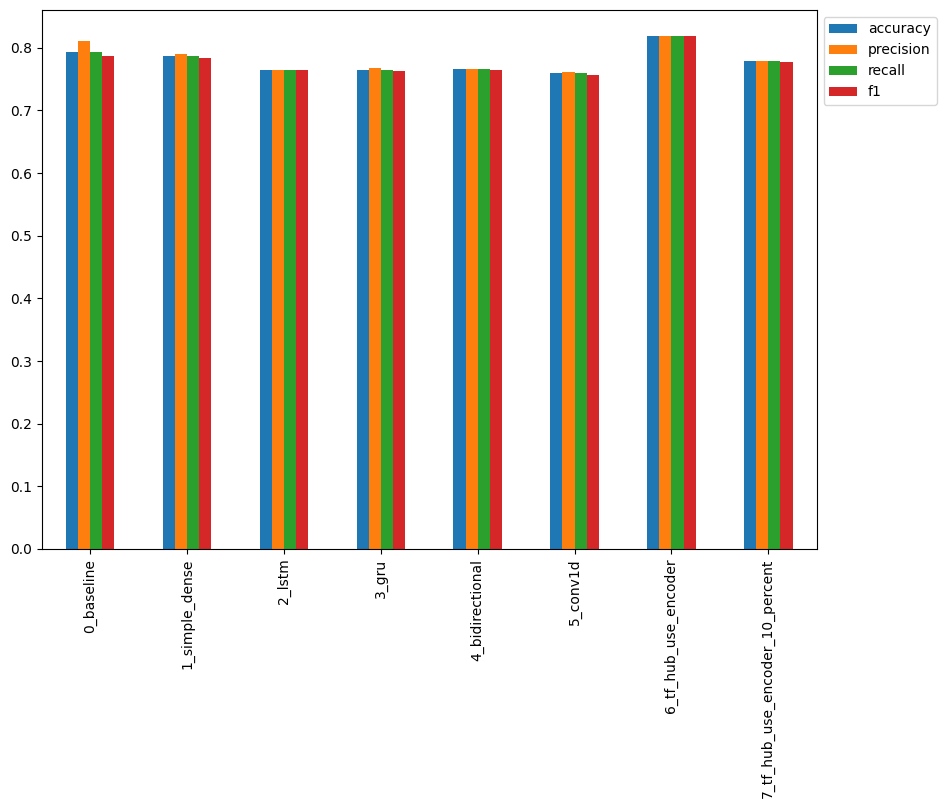

In [144]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

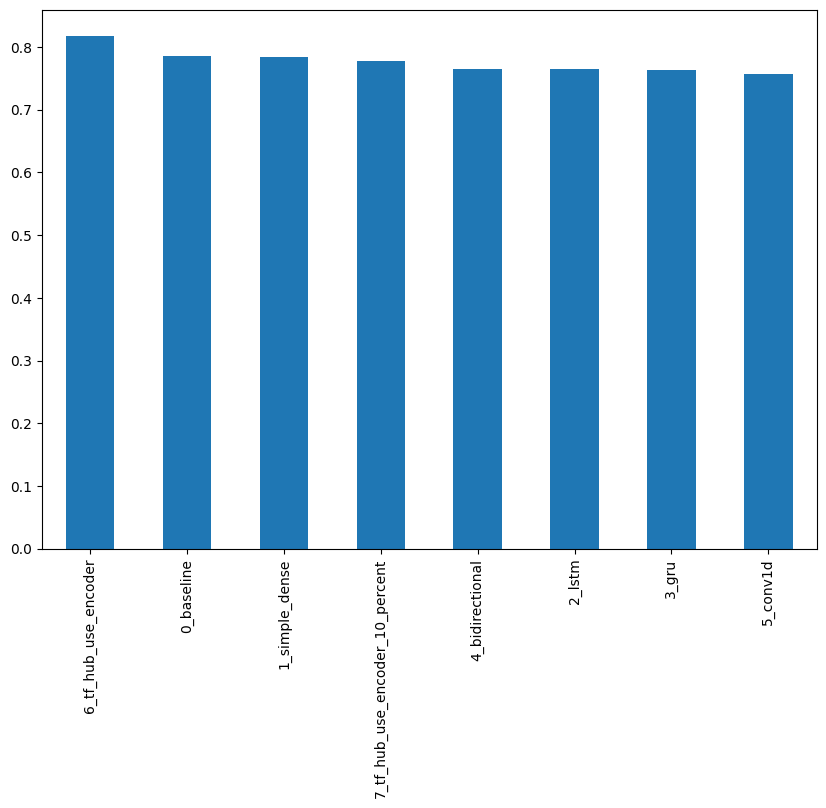

In [145]:
# Sort the model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind='bar', figsize=(10,7));

### Uploading all the model training logs to TensorBoard.dev integrated with Neptune AI

`Since TensorBoard.dev has being shut down and no uploading of model logs can be performed on it`

In [149]:
!pip install -U neptune-tensorboard
!pip install neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.6 MB/s eta 0:00:00


In [147]:
# Get the API token
NEPTUNE_API_TOKEN="API_KEY"

In [154]:
import neptune
from neptune_tensorboard import enable_tensorboard_logging

run = neptune.init_run(api_token=NEPTUNE_API_TOKEN,
                       project="shivin.m17/Tensorflow-NLP",
                       name="NLP Tensorflow model experiments",
                       description = "Comparing different kinds of ml / dl models to compare tweets, on whether they are disaster or not",
                       source_files=["/content/model_logs/model_1_dense",
                                     "/content/model_logs/model_2_LSTM"
                                     ],
                       capture_stdout = True,
                       capture_stderr = True,
                       capture_traceback = True,
                       capture_hardware_metrics = True
                       )

enable_tensorboard_logging(run)

https://app.neptune.ai/shivin.m17/Tensorflow-NLP/e/TEN-2


### Saving and loading a trained model

There are 2 main formats to save a model:
1. The HDF5 model
2. The SavedModel format

In [155]:
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8194821765774754,
 'recall': 0.8188976377952756,
 'f1': 0.8180640338279949}

#### Saving and loading the best model in HDF5 format

In [156]:
# Save model_6 to HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [157]:
# Load model with custom hub layer (rerquired with HHDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects = {"KerasLayer": hub.KerasLayer})

In [158]:
# How does the loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 20ms/step - loss: 0.4245 - accuracy: 0.8189


[0.42450836300849915, 0.8188976645469666]

#### Saving and loading the best model in SavedModel format

In [159]:
# Save TF Hub sentence encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

In [160]:
loaded_model_6_savedmodel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [161]:
# Evaluate the savedmodel format model
loaded_model_6_savedmodel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 2s 14ms/step - loss: 0.4245 - accuracy: 0.8189


[0.42450836300849915, 0.8188976645469666]

### Finding the most wrong examples

Here, checking out which samples are lowering the accuracy of the model (i.e which samples of the data are giving out the most wrong predictions closest to the opposite class)



In [162]:
# Download a pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-11-28 07:54:34--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.191.207, 209.85.200.207, 173.194.206.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.191.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M   171MB/s    in 9.2s    

2023-11-28 07:54:44 (99.4 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.

In [163]:
# Import previously trained model
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 13ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [164]:
# Make predictions using the pretrained loaded model
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 17ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [166]:
# Create DataFrame with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text":val_sentences,
                       "target":val_labels,
                       "pred":model_6_pretrained_preds,
                       "pred_probs":tf.squeeze(model_6_pretrained_pred_probs)})

val_df.head()

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [168]:
# Get the most wrong predictions
mosts_wrong_pred_df = val_df.sort_values(['target', 'pred_probs'], ascending=[True, False])
mosts_wrong_pred_df.head(10)

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


Here, we can see that for a target (with negative (0) target value), we are getting the opposite predictions (i.e. postive (1)) with higher probabilities. Thus, these results are `False Positives`.

In [169]:
mosts_wrong_pred_df.tail(10)

,text,target,pred,pred_probs
536,@DavidVonderhaar At least you were sincere ??,1,0.0,0.067303
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.055076
294,Lucas Duda is Ghost Rider. Not the Nic Cage ve...,1,0.0,0.054603
221,going to redo my nails and watch behind the sc...,1,0.0,0.054597
59,You can never escape me. Bullets don't harm me...,1,0.0,0.049637
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043919
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Here, we can see that for a target (with positive (1) target value), we are getting the opposite predictions (i.e. negative (0)) with higher probabilities. Thus, these results are `False Positives`.

In [171]:
# Check the false positives
for row in mosts_wrong_pred_df[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354544043540955
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132277488708
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [174]:
# Check the false negatives
for row in mosts_wrong_pred_df[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0.0, Prob: 0.06730346381664276
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0.0, Prob: 0.05507583171129227
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0.0, Prob: 0.05460337549448013
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0.0, Prob: 0.054597023874521255
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target: 1, Pred: 0.0, Prob: 0.049637261778116226
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0.0, Prob: 0.04391850158572197
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren

----

Target: 1, Pred: 0.0, Prob: 0.

### Making and visualising predictions on the test dataset

In [175]:
# Make predictions on the test dataset and visualise them
test_sentences = test_df["text"].to_list()
test_sentences[:10]

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan',
 "We're shaking...It's an earthquake",
 "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
 'Hey! How are you?',
 'What a nice hat?',
 'Fuck off!']

* 0 - Not a disaster
* 1 - disaster

In [180]:
# Creating test samples
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("-----\n")

1/1 [==============================] - 0s 36ms/step
Pred: 1, Prob: 0.9665746092796326
Text:
ErdoganÛªs Bloody Gambit: 
Max Zirngast in Jacobin:
On July 20 a suicide bombing took the lives of thirty-one... http://t.co/l1vN8zXLGG

-----

1/1 [==============================] - 0s 36ms/step
Pred: 0, Prob: 0.49696192145347595
Text:
I don't reckon Ross is dead actually they said 'has' Pete killed his own brother Ross has survived so much to just die from that??

-----

1/1 [==============================] - 0s 38ms/step
Pred: 0, Prob: 0.16849958896636963
Text:
Love wounds

-----

1/1 [==============================] - 0s 43ms/step
Pred: 1, Prob: 0.7574477195739746
Text:
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4

-----

1/1 [==============================] - 0s 37ms/step
Pred: 1, Prob: 0.5310122966766357
Text:
Oh a #wmata train derailed. Kind of disappointed how unsurprised I am.

-----

1/1 [=======

### Speed / Score trade-off

Since, in real world, the volume of data is too big to be comprehended.

Since the models have to work on such amounts of data, there is a need to check whether the predictions that we get are fast enough to make the work keep on going, while having the accurate performance it shows after being trained.

In [181]:
model_6_results

{'accuracy': 81.88976377952756,
 'precision': 0.8194821765774754,
 'recall': 0.8188976377952756,
 'f1': 0.8180640338279949}

In [182]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [183]:
# Making a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples
  """
  start_time = time.perf_counter()  # get start time
  model.predict(samples)   # Make predictions
  end_time = time.perf_counter()   # get end time

  # Calculate total time to get predictions
  total_time = end_time - start_time

  # total time taken per prediction
  time_per_pred = total_time / len(samples)

  return total_time, time_per_pred

In [184]:
# Calculate TF hub sentence encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model = model_6_pretrained,
                                                            samples = val_sentences)
print(f"Total time taken to predict: {model_6_total_pred_time}")
print(f"Total time taken per prediction: {model_6_time_per_pred}")

24/24 [==============================] - 0s 13ms/step
Total time taken to predict: 0.6875000549989636
Total time taken per prediction: 0.0009022310433057265


In [185]:
# Calculate baseline model time per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model = model_0,
                                                            samples = val_sentences)
print(f"Total time taken to predict: {baseline_total_pred_time}")
print(f"Total time taken per prediction: {baseline_time_per_pred}")

Total time taken to predict: 0.06608428099934827
Total time taken per prediction: 8.67247782143678e-05


In [186]:
# Get results for the pretrained model
model_6_pretrained_results = calculate_results(y_true = val_labels,
                                               y_pred = model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

Text(0, 0.5, 'F1-score')

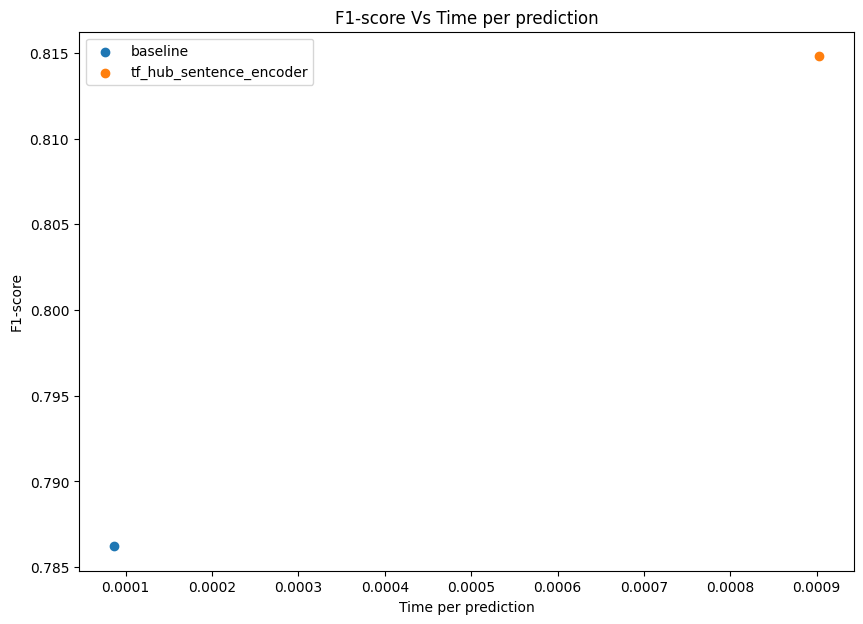

In [187]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label = "baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label = "tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score Vs Time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score")

Here, we can see that even though the difference between the f1-scores of `model_6_pretrained` and `baseline_model` is around `0.3`, the time it takes for the `model_6_pretrained` to predict a sample is about `10x` the time it takes for the `baseline_model`.

Thus, we can say that for real-world applications, the baseline_model is a better model to be used in an application.